<a href="https://colab.research.google.com/github/SSnehitha004/Deep_Learning_Projects/blob/main/Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colorama

Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import load_img, array_to_img, img_to_array
from tensorflow.keras.optimizers import Adam
import random
import os
from tqdm.notebook import tqdm

%matplotlib inline

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

Data Prepration

In [ ]:
BASE_DIR= '/content/drive/MyDrive/input/segmentation_full_body_mads_dataset_1192_img'
img_path= os.listdir(BASE_DIR+'images')
mask_path= os.listdir(BASE_DIR+'masks')

In [ ]:
img_size = 256

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_path, mask_path, test_size=0.2, random_state=22)

In [ ]:
def load_img(path):
    img= cv2.imread(path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
def load_data(path_list, gray=False):
    data=[]
    for path in tqdm(path_list):
        img= load_img(path)
        if gray:
            img= img[:, :, 0:1]
        img= cv2.resize(img, (img_size, img_size))
        data.append(img)
    return np.array(data)

In [ ]:
X_train= load_data([BASE_DIR + 'images/' + x for x in X_train])/255.0
X_test= load_data([BASE_DIR + 'images/' + x for x in X_test])/255.0

  0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

In [ ]:
Y_train= load_data([BASE_DIR + 'masks/' + x for x in y_train], gray=True)/255.0
Y_test= load_data([BASE_DIR + 'masks/' + x for x in y_test], gray=True)/255.0
Y_train= Y_train.reshape(-1, img_size, img_size, 1)
Y_test= Y_test.reshape(-1, img_size, img_size, 1)

  0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

In [ ]:
print(f"===( Train )===")
print(f"Images shape : {X_train.shape}")
print(f"Masks shape : {Y_train.shape}")

print(f"===( Test )===")
print(f"Images shape : {X_test.shape}")
print(f"Masks shape : {Y_test.shape}")

===( Train )===
Images shape : (953, 256, 256, 3)
Masks shape : (953, 256, 256, 1)
===( Test )===
Images shape : (239, 256, 256, 3)
Masks shape : (239, 256, 256, 1)


In [ ]:
def conv_block(shape, out_ch, rate=1):
    x = tf.keras.layers.Conv2D(out_ch, 3, padding="same", dilation_rate=1)(shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def RSU_L(shape, out_ch, M_ch, num_layers, rate=2):
    x = conv_block(shape, out_ch)
    inp_ch = x

    skip_features = []
    x = conv_block(x, M_ch)
    skip_features.append(x)

    for i in range(num_layers-2):
        x = tf.keras.layers.MaxPool2D((2, 2))(x)
        x = conv_block(x, M_ch)
        skip_features.append(x)

    x = conv_block(x, M_ch, rate=rate)
    skip_features.reverse()
    x = tf.keras.layers.Concatenate()([x, skip_features[0]])
    x = conv_block(x, M_ch)

    for i in range(num_layers-3):
        x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = tf.keras.layers.Concatenate()([x, skip_features[i+1]])
        x = conv_block(x, M_ch)

    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, skip_features[-1]])
    x = conv_block(x, out_ch)

    x = tf.keras.layers.Add()([x, inp_ch])
    return x

def RSU_4F(shape, out_ch, M_ch):
    x0 = conv_block(shape, out_ch, rate=1)

    x1 = conv_block(x0, M_ch, rate=1)
    x2 = conv_block(x1, M_ch, rate=2)
    x3 = conv_block(x2, M_ch, rate=4)

    x4 = conv_block(x3, M_ch, rate=8)

    x = tf.keras.layers.Concatenate()([x4, x3])
    x = conv_block(x, M_ch, rate=4)

    x = tf.keras.layers.Concatenate()([x, x2])
    x = conv_block(x, M_ch, rate=2)

    x = tf.keras.layers.Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    x = tf.keras.layers.Add()([x, x0])
    return x

def u2net(shape, out_ch, M_ch, num_classes=1):
    inputs = tf.keras.layers.Input(shape)

    e1 = RSU_L(inputs, out_ch[0], M_ch[0], 7)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(e1)

    e2 = RSU_L(p1, out_ch[1], M_ch[1], 6)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(e2)

    e3 = RSU_L(p2, out_ch[2], M_ch[2], 5)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(e3)

    e4 = RSU_L(p3, out_ch[3], M_ch[3], 4)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(e4)

    e5 = RSU_4F(p4, out_ch[4], M_ch[4])
    p5 = tf.keras.layers.MaxPool2D((2, 2))(e5)

    b1 = RSU_4F(p5, out_ch[5], M_ch[5])
    b2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    d1 = tf.keras.layers.Concatenate()([b2, e5])
    d1 = RSU_4F(d1, out_ch[6], M_ch[6])
    u1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = tf.keras.layers.Concatenate()([u1, e4])
    d2 = RSU_L(d2, out_ch[7], M_ch[7], 4)
    u2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = tf.keras.layers.Concatenate()([u2, e3])
    d3 = RSU_L(d3, out_ch[8], M_ch[8], 5)
    u3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    d4 = tf.keras.layers.Concatenate()([u3, e2])
    d4 = RSU_L(d4, out_ch[9], M_ch[9], 6)
    u4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = tf.keras.layers.Concatenate()([u4, e1])
    d5 = RSU_L(d5, out_ch[10], M_ch[10], 7)


    y1 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d5)

    y2 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d4)
    y2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d3)
    y3 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d2)
    y4 = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d1)
    y5 = tf.keras.layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(b1)
    y6 = tf.keras.layers.UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(y0)

    y0 = tf.keras.layers.Activation("sigmoid")(y0)
    y1 = tf.keras.layers.Activation("sigmoid")(y1)
    y2 = tf.keras.layers.Activation("sigmoid")(y2)
    y3 = tf.keras.layers.Activation("sigmoid")(y3)
    y4 = tf.keras.layers.Activation("sigmoid")(y4)
    y5 = tf.keras.layers.Activation("sigmoid")(y5)
    y6 = tf.keras.layers.Activation("sigmoid")(y6)

    model = tf.keras.models.Model(inputs, outputs=y0, name="U2-Net")
    return model

def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    M_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model

def build_u2net_lite(input_shape, num_classes=1):
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    M_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model

u2net_model = build_u2net((img_size, img_size, 3))
u2net_model.summary()

Model: "U2-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][

Model Training

In [ ]:
opt = Adam(learning_rate=1e-3)
u2net_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = ModelCheckpoint('full_body.hdf5',verbose=1, save_best_only= True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, checkpoint, early_stop]

In [ ]:
hsitory = u2net_model.fit(X_train, Y_train, validation_split = 0.2, batch_size = 16, epochs = 30, callbacks=get_callbacks())

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9613
Epoch 1: val_loss improved from inf to 18785.47461, saving model to full_body.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 225s 2s/step - loss: 0.1586 - accuracy: 0.9613 - val_loss: 18785.4746 - val_accuracy: 0.0484 - lr: 0.0010
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9778
Epoch 2: val_loss improved from 18785.47461 to 3.41962, saving model to full_body.hdf5
48/48 [==============================] - 53s 1s/step - loss: 0.0204 - accuracy: 0.9778 - val_loss: 3.4196 - val_accuracy: 0.6638 - lr: 0.0010
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9794
Epoch 3: val_loss improved from 3.41962 to 0.77764, saving model to full_body.hdf5
48/48 [==============================] - 55s 1s/step - loss: 0.0148 - accuracy: 0.9794 - val_loss: 0.7776 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9799
Epoch 4: val_loss did not improve from 0.77764
48/48 [==============================] - 48s 999ms/step - loss: 0.0128

Model testing

In [ ]:
u2net_model.load_weights("full_body.hdf5")

In [ ]:
predict = u2net_model.predict(X_test)

8/8 [==============================] - 32s 485ms/step


In [ ]:
def show_result(og, pred, target):
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("Predict")
    axs[1].imshow(pred)
    axs[1].axis('off')

    axs[2].set_title("Target")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [ ]:
show_test_idx = random.sample(range(239), 5)

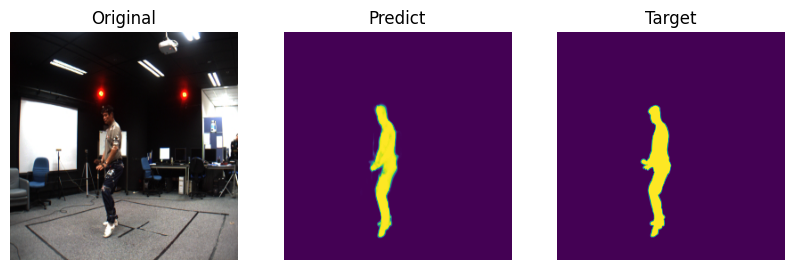

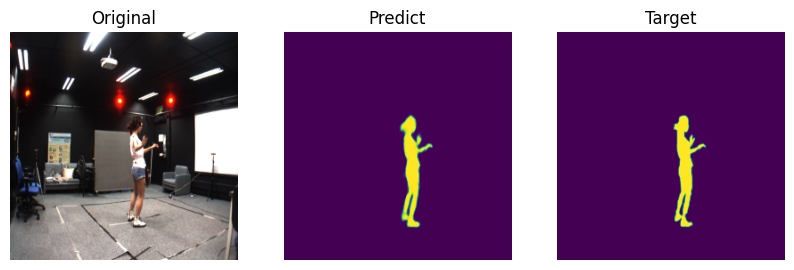

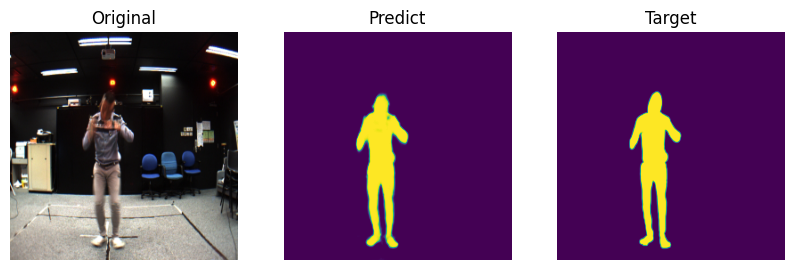

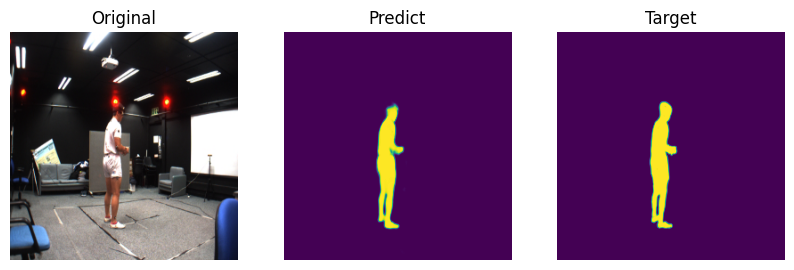

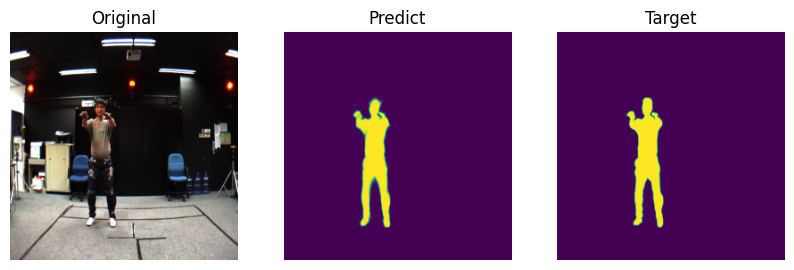

In [ ]:
for idx in show_test_idx:
    show_result(X_test[idx], predict[idx], Y_test[idx])

Evaluation

In [ ]:
loss, accuracy = u2net_model.evaluate(X_test, Y_test)

8/8 [==============================] - 4s 513ms/step - loss: 0.0107 - accuracy: 0.9770


In [ ]:
print(f"Test Loss : {loss}")
print(f"Test Accuracy : {accuracy}")

Test Loss : 0.010710467584431171
Test Accuracy : 0.976986825466156
